### Imported Libararies

In [3]:
# data api
import yfinance as yf
from fredapi import Fred

# data processor
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from dotenv import load_dotenv
import os

ROOT = Path.cwd()  # or your project root
from utilities import *

# Load environment variables from .env
load_dotenv()

# Access variables
fred_key = os.getenv("FRED_API_KEY")
fred = Fred(api_key=fred_key) # fred is an object - an instance of the `Fred` Class # can apply your own api_key on the website, quite easy

## Data Preparation

### 1 - Financial Turbulence

The identification of financial turbulence allows for a deeper understanding of market dynamics and the potential risks associated with market-wide disruptions.  

They measure financial turbulence as:

$$
d_t = (y_t - \mu)' \Sigma^{-1} (y_t - \mu) 
$$

where:

- $d_t$ = turbulence for a particular time period $t$  
- $y_t$ = vector of asset returns for period $t$  
- $\mu$ = sample average vector of historical returns  
- $\Sigma$ = sample covariance matrix of historical returns

|  Ticker  | Sector Name (English)                     | Notes                                       |
| :------: | :---------------------------------------- | :------------------------------------------ |
|  **XLK** | Technology Select Sector SPDR             | Tracks S&P 500 Information Technology Index |
|  **XLF** | Financial Select Sector SPDR              | S&P 500 Financials Index                    |
|  **XLE** | Energy Select Sector SPDR                 | Oil & gas producers, energy equipment       |
|  **XLI** | Industrial Select Sector SPDR             | Transportation, manufacturing, aerospace    |
|  **XLP** | Consumer Staples Select Sector SPDR       | Food, beverages, household goods            |
|  **XLY** | Consumer Discretionary Select Sector SPDR | Retail, automotive, luxury, entertainment   |
|  **XLU** | Utilities Select Sector SPDR              | Electric and gas utilities companies        |
|  **XLB** | Materials Select Sector SPDR              | Chemicals, metals, construction materials   |
|  **XLC** | Communication Services Select Sector SPDR | Telecom & media (e.g. Meta, Alphabet)       |
| **XLRE** | Real Estate Select Sector SPDR            | Real estate investment trusts (REITs)       |

- These are sector ETFs - exchange-traded funds that track the S&P500 sector indices.

---
Some comments of this concept:<br>
- The indicator **Financial turbulence** is actually a kind of **Mahalanobis distance**.<br>
- Mahalanobis distance measures how many standard deviations a point is from the mean, considering correlations between variables. You can think of it as an oval.
- It’s essentially the Euclidean distance in a whitened (decorrelated and standardized) space, obtained by using the inverse covariance matrix to rotate and scale the data, making the comparison more objective.


Prerequisites of calculating **Mahalanobis distance**:

| Concept                        | Requirement                                                    | Why it matters                                                               |
| ------------------------------ | -------------------------------------------------------------- | ---------------------------------------------------------------------------- |
| **Covariance invertibility**   | ($\Sigma$) must be **positive definite** (invertible)            | Otherwise ($\Sigma^{-1}$) doesn’t exist                                        |
| **Sufficient historical data** | Number of observations (N > p) (assets)                        | Needed to estimate a stable covariance matrix                                |
| **Stationarity (approx.)**     | The distribution of returns shouldn’t drift too fast over time | So that μ and Σ estimated from history are meaningful for the current period |
| **No exact multicollinearity** | Assets must not be perfectly correlated                        | Otherwise covariance matrix is singular                                      |


In [4]:
tickers = ["XLK","XLF","XLE","XLI","XLP","XLY","XLU","XLB"]  # exclude "XLC", "XLRE" 
sp_sectors_data = yf.download(tickers, start="1999-11-30", end="2025-8-31", interval="1mo")["Close"]
sp_sectors_returns = sp_sectors_data.pct_change().dropna()

[*********************100%***********************]  8 of 8 completed


In [5]:
# sp_sectors_data
sp_sectors_returns

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLY
Date,,,,,,,,
2000-01-01,-0.118590,0.011047,-0.026024,-0.078156,-0.061466,0.011767,-0.011504,-0.123149
2000-02-01,-0.100469,-0.042334,-0.107046,-0.055173,0.105068,-0.117014,-0.121537,-0.055715
2000-03-01,0.098288,0.120669,0.178300,0.136861,0.083893,0.034273,0.101029,0.139294
2000-04-01,-0.030927,-0.011625,0.013363,0.016539,-0.091848,0.056400,0.073402,-0.018912
2000-05-01,-0.031556,0.117424,0.022321,-0.004219,-0.103977,0.071328,-0.002194,-0.053980
...,...,...,...,...,...,...,...,...
2025-04-01,-0.019657,-0.131858,-0.017524,0.004220,0.018688,0.007267,0.007736,0.001737
2025-05-01,0.029205,0.012795,0.045119,0.088401,0.099728,0.012220,0.038276,0.083849
2025-06-01,0.017026,0.040231,0.027669,0.032909,0.096661,-0.022456,-0.003174,0.016511


In [6]:
# Download the Treasury yields (daily frequenciy)
tickers = { # Define a dict mapping FRED series IDs to readable labels 
    "GS1" : "1Y", # 1 year constant maturity
    "GS2" : "2Y",
    "GS10" : "10Y"
}

treasury_yields = pd.DataFrame({label: fred.get_series(ticker) for ticker, label in tickers.items()})["2000-01-01":"2025-08-31"] # the data frequency is already monthly
    # In FRED's terminology, a series is one time sries of economic data

In [7]:
treasury_yields

,1Y,2Y,10Y
2000-01-01,6.12,6.44,6.66
2000-02-01,6.22,6.61,6.52
2000-03-01,6.22,6.53,6.26
2000-04-01,6.15,6.40,5.99
2000-05-01,6.33,6.81,6.44
...,...,...,...
2025-04-01,3.95,3.78,4.28
2025-05-01,4.09,3.92,4.42
2025-06-01,4.06,3.89,4.38
2025-07-01,4.08,3.88,4.39


In [8]:
combined_treasury_rate_sp_sectors_returns = pd.concat([sp_sectors_returns*100, treasury_yields], axis=1)

In [9]:
combined_treasury_rate_sp_sectors_returns 

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLY,1Y,2Y,10Y
2000-01-01,-11.858986,1.104715,-2.602370,-7.815584,-6.146633,1.176695,-1.150376,-12.314916,6.12,6.44,6.66
2000-02-01,-10.046917,-4.233428,-10.704630,-5.517258,10.506803,-11.701403,-12.153708,-5.571466,6.22,6.61,6.52
2000-03-01,9.828753,12.066888,17.830047,13.686093,8.389286,3.427274,10.102936,13.929434,6.22,6.53,6.26
2000-04-01,-3.092666,-1.162481,1.336339,1.653895,-9.184778,5.639968,7.340156,-1.891215,6.15,6.40,5.99
2000-05-01,-3.155604,11.742362,2.232149,-0.421903,-10.397745,7.132844,-0.219409,-5.398040,6.33,6.81,6.44
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-1.965704,-13.185826,-1.752443,0.421964,1.868791,0.726664,0.773632,0.173681,3.95,3.78,4.28
2025-05-01,2.920484,1.279496,4.511893,8.840110,9.972848,1.222038,3.827634,8.384872,4.09,3.92,4.42
2025-06-01,1.702572,4.023061,2.766876,3.290855,9.666105,-2.245557,-0.317379,1.651077,4.06,3.89,4.38
2025-07-01,0.417846,3.666359,0.342707,3.357267,3.927441,-0.793781,5.639001,2.103160,4.08,3.88,4.39


In [10]:

exploratory_data_analysis_pd_dataframe(combined_treasury_rate_sp_sectors_returns)

The shape:
(308, 11)

The number of na data:
XLB    0
XLE    0
XLF    0
XLI    0
XLK    0
XLP    0
XLU    0
XLY    0
1Y     0
2Y     0
10Y    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLB     308 non-null    float64
 1   XLE     308 non-null    float64
 2   XLF     308 non-null    float64
 3   XLI     308 non-null    float64
 4   XLK     308 non-null    float64
 5   XLP     308 non-null    float64
 6   XLU     308 non-null    float64
 7   XLY     308 non-null    float64
 8   1Y      308 non-null    float64
 9   2Y      308 non-null    float64
 10  10Y     308 non-null    float64
dtypes: float64(11)
memory usage: 28.9 KB
None

The numberic profile of the input data:
              XLB         XLE         XLF         XLI         XLK         XLP  \
count  308.000000  308.000000  308.

In [11]:
def compute_financial_turbulence(returns_df: pd.DataFrame) -> pd.Series:
    """
    Compute the Financial Turbulence Index following Kritzman & Li (2010).

    Parameters
    ----------
    returns_df : pd.DataFrame
        DataFrame of asset returns (each column is one asset, e.g., sectors or Treasuries).
        Data should be stationary and aligned by date.

    Returns
    -------
    pd.Series
        Financial Turbulence values indexed by date.
    """
    data = returns_df.copy()
    mu = data.mean().values
    cov = data.cov().values

    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix is singular or ill-conditioned.")
    
    diff = data.values - mu
    turbulence_array = np.einsum('ij, jk, ik ->i', diff, inv_cov, diff)
    turbulence = pd.Series(turbulence_array, index = data.index, name = "financial_turbulence")

    return turbulence

In [12]:
financial_turbulence = compute_financial_turbulence(combined_treasury_rate_sp_sectors_returns)
financial_turbulence.name = 'financial_turbulence'

In [13]:
exploratory_data_analysis_pd_dataframe(financial_turbulence)


The shape:
(308,)

The number of na data:
0

The Info of the input dataframe:
<class 'pandas.core.series.Series'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Series name: financial_turbulence
Non-Null Count  Dtype  
--------------  -----  
308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
count    308.000000
mean      10.964286
std        7.751140
min        2.124768
25%        5.731493
50%        8.371998
75%       13.452714
max       44.591179
Name: financial_turbulence, dtype: float64

The skewness of the input dataframe:
1.720762971085558

The kurtosis of the input dataframe:
3.148235768181141


### 2 - Financial Condition

Variables:
- Financial Condition – Risk
- Financial Condition – Credit
- Financial Condition – Leverage
Source: “FRED, National Financial Conditions Index”

These come from the Chicago Fed’s National Financial Conditions Index (NFCI), which actually has subindexes: Risk, Credit, and Leverage.

In [14]:
tickers = {
    "NFCIRISK": "nfc_risk",
    "NFCICREDIT": "nfc_credit",
    "NFCILEVERAGE": "nfc_leverage"
}

nfc = pd.DataFrame({name: fred.get_series(ticker) for ticker, name in tickers.items()})

In [15]:
nfc

,nfc_risk,nfc_credit,nfc_leverage
1971-01-08,0.61212,-1.12905,-1.03535
1971-01-15,0.64162,-1.13101,-1.05320
1971-01-22,0.67665,-1.13421,-1.06969
1971-01-29,0.71577,-1.13910,-1.08418
1971-02-05,0.75783,-1.14617,-1.09618
...,...,...,...
2025-10-03,-0.58416,-0.04464,-0.19125
2025-10-10,-0.58401,-0.04310,-0.15219
2025-10-17,-0.58254,-0.04147,-0.11647
2025-10-24,-0.58121,-0.03994,-0.08567


In [16]:
def data_process_helper(data:pd.DataFrame) -> pd.DataFrame:
    data_monthly = data.resample('M').mean()
    data_sliced = data_monthly.loc['2000-01-01':'2025-09-01']
    data_sliced.index = data_sliced.index.to_period('M').to_timestamp('M')  # currently end-of-month
    data_sliced.index = data_sliced.index.to_period('M').to_timestamp('S')  # ← start-of-month
    return data_sliced

In [17]:
type(financial_turbulence)

pandas.core.series.Series

In [18]:
financial_condition = data_process_helper(nfc)
exploratory_data_analysis_pd_dataframe(financial_condition)

The shape:
(308, 3)

The number of na data:
nfc_risk        0
nfc_credit      0
nfc_leverage    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Freq: MS
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nfc_risk      308 non-null    float64
 1   nfc_credit    308 non-null    float64
 2   nfc_leverage  308 non-null    float64
dtypes: float64(3)
memory usage: 9.6 KB
None

The numberic profile of the input data:
         nfc_risk  nfc_credit  nfc_leverage
count  308.000000  308.000000    308.000000
mean    -0.377825    0.066171     -0.021269
std      0.504857    0.426708      0.921814
min     -0.798570   -0.436042     -1.970656
25%     -0.651411   -0.127908     -0.453421
50%     -0.522617   -0.021577     -0.173749
75%     -0.312148    0.150266      0.145729
max      2.856655    2.682325      3.902172

The skewness of the input

In [19]:
financial_condition

,nfc_risk,nfc_credit,nfc_leverage
2000-01-01,-0.258570,0.058478,1.317603
2000-02-01,-0.246968,0.025660,1.351058
2000-03-01,-0.155668,0.063858,1.181748
2000-04-01,-0.033340,0.119385,0.876302
2000-05-01,0.061378,0.159085,0.602598
...,...,...,...
2025-04-01,-0.403042,0.017880,-0.419015
2025-05-01,-0.446606,-0.008484,-0.455824
2025-06-01,-0.503590,-0.036160,-0.520180
2025-07-01,-0.538555,-0.048125,-0.525730


#### 2.1 Interpretation of these 3 feature

| Subindex                             | What It Measures                                                   | Interpretation of High Values (>0)                                    | Interpretation of Low Values (<0)                             | Notes                                                    |
| ------------------------------------ | ------------------------------------------------------------------ | --------------------------------------------------------------------- | ------------------------------------------------------------- | -------------------------------------------------------- |
| **Risk Subindex (NFCRISK)**          | Market risk appetite, volatility, credit spreads, funding stress   | Higher market stress, rising volatility, tighter risk conditions      | Lower stress, calm markets, easier risk-taking                | Standardized Z-score (mean 0, std 1)                     |
| **Credit Subindex (NFCICREDIT)**     | Lending conditions for households and firms; bank credit standards | Tighter credit supply, stricter lending, rising borrowing constraints | Easier lending conditions, credit flowing freely              | Negative values = accommodative credit environment       |
| **Leverage Subindex (NFCILEVERAGE)** | Balance-sheet leverage of financial intermediaries; leverage cycle | Deleveraging, balance-sheet contraction, tighter financial conditions | Leveraging-up, expansion of balance sheets, looser conditions | Captures broker-dealer leverage and funding availability |
| **Common Scale**                     | All three are standardized factors                                 | Values > +1 = unusually tight                                         | Values < –1 = unusually easy                                  | Derived from 100+ market/credit variables                |


The three NFCI subindexes — Risk, Credit, and Leverage — are not produced using simple linear regression.


They are generated using a Dynamic Factor Model (DFM), estimated through Kalman filtering. (`too much stuff to learn, skip it temporarily`)

### 3 - Equity Valuation

Variable:
- Cyclically Adjusted PE Ratio (CAPE Ratio)
- Source: “Online Data Robert Shiller” (http://www.econ.yale.edu/~shiller/data.htm)
Robert Shiller (Yale) publishes this for free (CAPE, earnings yield = 1/CAPE). We can download the Excel/CSV manually from his website and then load with pandas. 

`Caveat:`
- This data source only contain the **CAPE Ratio for stocks in S&P500**, but our factor data is based on the **Ken French Data Library**, which covers all NYSE, AMEX, and NASDAQ stocks (broader). Might need further modification.

In [20]:
ROOT = Path.cwd() # current working directory
PROC = ROOT / os.getenv("DATA_DIR_PROCESSED")
shiller_data = pd.read_excel(PROC/"ie_data.xls", sheet_name='Data', skiprows=7)

print(shiller_data.head())

      Date     P     D    E        CPI     Fraction Rate GS10       Price  \
0  1871.01  4.44  0.26  0.4  12.464061  1871.041667      5.32  115.656018   
1  1871.02   4.5  0.26  0.4  12.844641  1871.125000  5.323333  113.745800   
2  1871.03  4.61  0.26  0.4  13.034972  1871.208333  5.326667  114.824791   
3  1871.04  4.74  0.26  0.4  12.559226  1871.291667      5.33  122.535037   
4  1871.05  4.86  0.26  0.4  12.273812  1871.375000  5.333333  128.558754   

   Dividend     Price.1  ...  CAPE  Unnamed: 13  TR CAPE  Unnamed: 15  Yield  \
0  6.772650  115.656018  ...   NaN          NaN      NaN          NaN    NaN   
1  6.571980  114.293465  ...   NaN          NaN      NaN          NaN    NaN   
2  6.476019  115.919917  ...   NaN          NaN      NaN          NaN    NaN   
3  6.721331  124.269152  ...   NaN          NaN      NaN          NaN    NaN   
4  6.877629  130.959363  ...   NaN          NaN      NaN          NaN    NaN   

    Returns  Returns.1  Real Return  Real Return.1  Retu

Diff between the CAPE and TR CAPE

| Column name   | Meaning        | Key difference      |
| ------------------------- | ------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **CAPE (or P/E10)**       | *Cyclically Adjusted Price–Earnings Ratio*       | Uses **S&P 500 price index** only (no dividends). Measures how expensive the market’s **price level** is relative to 10-year average earnings.                                                      |
| **TR CAPE (or TR P/E10)** | *Cyclically Adjusted **Total Return** P/E Ratio* | Uses **total-return index** instead of price index. That means it assumes **dividends are reinvested**, so prices grow faster. It adjusts the “P” part to reflect cumulative dividend reinvestment. |


$$
\text{CAPE} = \frac{\text{Price Index}}{\text{10-Year Average Real Earnings}}
$$

$$
\text{TR CAPE} = \frac{\text{Total Return Index (Price + Reinvested Dividends)}}{\text{10-Year Average Real Earnings}}
$$



In [21]:
cape = shiller_data[['Date', 'TR CAPE']].dropna() # here we use the TR CAPE (Cyclically Adjusted PE Ratio)

# convert the data type and set it as the index 
date_num = cape["Date"].astype(float)
year = date_num.astype(int)
month = ((date_num - year) * 100).round().astype(int).clip(1, 12)
dt = pd.to_datetime(dict(year=year, month=month, day=1))
cape = cape.drop(columns=["Date"]).assign(Date=dt).set_index("Date").sort_index()

# set the time range
cape = cape.loc['2000-01-01': '2025-08-01']
equity_valuation = cape.copy()

In [22]:
exploratory_data_analysis_pd_dataframe(cape) # the result show that do not need interplation

The shape:
(308, 1)

The number of na data:
TR CAPE    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TR CAPE  308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
          TR CAPE
count  308.000000
mean    30.020385
std      6.154087
min     14.592704
25%     25.914007
50%     29.137699
75%     33.478754
max     47.587687

The skewness of the input dataframe:
TR CAPE    0.454212
dtype: float64

The kurtosis of the input dataframe:
TR CAPE    0.337856
dtype: float64


#### 3.1 More Background Info of this feature

- link: https://shillerdata.com

- US Stock market data used in my book, Irrational Exuberance [Princeton University Press[BS1]  2000, Broadway Books 2001, 2nd  ed., 2005, 3rd ed. 2015] as updated are available for download below. This data set consists of monthly stock price, dividends, and earnings data and interest rates and the consumer price index (to allow conversion to real values), starting January 1871. The price, dividend, and earnings series are from the same sources as described in Chapter 26 of my book (Market Volatility [Cambridge, MA: MIT Press, 1989]), although now I provide monthly data, rather than annual data. Monthly dividend and earnings data are computed from the S&P four-quarter totals for the quarters since 1926, with linear interpolation to monthly figures. Dividend and earnings data before 1926 are from Cowles and Associates (Common Stock Indexes, 2nd ed. [Bloomington, Ind.: Principia Press, 1939]), interpolated from annual data. Stock price data are monthly averages of daily closing prices. The CPI-U (Consumer Price Index-All Urban Consumers) published by the U.S. Bureau of Labor Statistics begins in 1913; for years before 1913 I spliced to the CPI Warren and Pearson's price index, by multiplying it by the ratio of the indexes in January 1913. See George F. Warren and Frank A. Pearson, Gold and Prices (New York: John Wiley and Sons, 1935). Data are from their Table 1, pp. 11–14.

- As of September 2018, I now also include an alternative total return version of the data that is somewhat different. As documented in Bunn & Shiller (2014) and Jivraj and Shiller (2017), changes in corporate payout policy (i. e. share repurchases rather than dividends) have now become a dominant approach in the United States for cash distribution to shareholders). This may affect the level of the CAPE ratio through changing the growth rate of earnings per share. This subsequently may affect the average of the real earnings per share used in the CAPE ratio. A total return CAPE corrects for this bias through reinvesting dividends into the price index and appropriately scaling of earnings per share.


### 4 - Monetary Policy Expectation

Varibales:
- Effective Federal Funds Rate
- Monetary Policy Expectations


Monetary Policy Expectations is vague. In practice, people proxy it with:
- Fed Funds futures implied rate,
- OIS curve near-term expectations,
- or Survey-based expectations.

Those are usually not free (they’re from CME futures, Bloomberg, Refinitiv). The paper is almost certainly using some proprietary forward-rate expectation measure. Since we cannot access policy expectations so far. We add a similar feature: 
- 3M-FFR spread (3 month treasury yield - effective fed funds rate) which reflects the near-term policy.





In [23]:
effr = fred.get_series('FEDFUNDS').loc['2000-01-01': '2025-08-01']   # Retrieve Effective Federal Funds Rate (FEDFUNDS)
effr.name = 'effr'
t3m = fred.get_series('DGS3MO')      # 3-month Treasury yield
t3m_m = t3m.resample('M').mean()
t3m_m.index = t3m_m.index.to_period('M').to_timestamp('S')
t3m_m = t3m_m.loc['2000-01-01': '2025-08-01']

expectation_proxy = t3m_m - effr        # 3M-FFR spread
expectation_proxy.name = 't3m effr spread'

monetary_policy_expectation = pd.concat([effr, expectation_proxy], axis = 1)


In [24]:
effr

2000-01-01    5.45
2000-02-01    5.73
2000-03-01    5.85
2000-04-01    6.02
2000-05-01    6.27
              ... 
2025-04-01    4.33
2025-05-01    4.33
2025-06-01    4.33
2025-07-01    4.33
2025-08-01    4.33
Name: effr, Length: 308, dtype: float64

In [25]:
exploratory_data_analysis_pd_dataframe(expectation_proxy)
exploratory_data_analysis_pd_dataframe(effr)

The shape:
(308,)

The number of na data:
0

The Info of the input dataframe:
<class 'pandas.core.series.Series'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Freq: MS
Series name: t3m effr spread
Non-Null Count  Dtype  
--------------  -----  
308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
count    308.000000
mean      -0.064596
std        0.246398
min       -1.326500
25%       -0.099625
50%       -0.044665
75%        0.022174
max        0.792500
Name: t3m effr spread, dtype: float64

The skewness of the input dataframe:
-1.6779871419551902

The kurtosis of the input dataframe:
7.227066600475236
The shape:
(308,)

The number of na data:
0

The Info of the input dataframe:
<class 'pandas.core.series.Series'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Series name: effr
Non-Null Count  Dtype  
--------------  -----  
308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile o

#### 4.1 Interpretation of these features 

Effective Federal Funds Rate (EFFR)

FRED series code: FEDFUNDS

It represents:

The weighted-average interest rate at which depository institutions lend reserve balances to each other overnight.

This is the key short-term interest rate in the U.S. financial system.

### A - Target Index Market regimes

S&P 500 data and three months' rolling drawdown calculation.

In [26]:
sp = yf.download("^GSPC", start="1999-01-01", end="2025-09-01", interval="1d") # ^GSPC is the ticker symbol for the S&P 500 Index on Yahoo Finance.
    # move the start date one year before to adapt the rolling window
sp_close = sp['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


The formula for calculating RollingDrawdown based on S&P 500 data:

$$RollingDrawdown(t) = \dfrac{P_t - \max_{t-63 \le s \le t} P_s}{\max_{t-63 \le s \le t} P_s}$$

In [27]:
sp

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1999-01-04,1228.099976,1248.810059,1219.099976,1229.229980,877000000
1999-01-05,1244.780029,1246.109985,1228.099976,1228.099976,775000000
1999-01-06,1272.339966,1272.500000,1244.780029,1244.780029,986900000
1999-01-07,1269.729980,1272.339966,1257.680054,1272.339966,863000000
1999-01-08,1275.089966,1278.239990,1261.819946,1269.729980,937800000
...,...,...,...,...,...
2025-08-25,6439.319824,6466.890137,6438.060059,6457.669922,4059070000
2025-08-26,6465.939941,6468.370117,6429.209961,6435.490234,4867680000


In [28]:
# Compute rolling 3-month (≈63 trading days) peak 
window = 63  # ~3 months of trading days
rolling_peak = sp_close.rolling(window=window, min_periods=1).max()
rolling_dd = (sp_close - rolling_peak) / rolling_peak   # this will be 0 at local peaks, negative otherwise
rolling_dd_=rolling_dd.dropna()

monthly_rolling_dd = rolling_dd.resample('M').min() # Downsample to monthly to make a cleaner plot like Exhibit 2 in page 5
    # We take the MIN within each month because drawdown is about worst pain
monthly_rolling_dd.index = monthly_rolling_dd.index.to_period('M').to_timestamp('S')
    # to_peroid means xxxx-xx
    # to_timestamp means xxxx-xx-xx
monthly_rolling_dd = monthly_rolling_dd.loc['2000-01-01':'2025-08-01']

In [29]:
type(monthly_rolling_dd)

pandas.core.frame.DataFrame

In [30]:
sp_3m_drawdown= monthly_rolling_dd.rename(columns = {'^GSPC' : 'sp_3m_drawdown'})

In [31]:
# from utilities import plot_maxdrawdown_series

# plot_maxdrawdown_series(monthly_rolling_dd)

In [32]:
sp_3m_drawdown = monthly_rolling_dd.copy()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Prepare X (2D array) and keep dates for merging back
col = sp_3m_drawdown.columns[0]
X = sp_3m_drawdown[[col]].astype(float).values  # shape (T, 1)

# 2) Scale (important for distance-based methods, even in 1D)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# 3) (Optional) Elbow method to check K
def wcss_for_k(max_k=8):
    wcss = []
    for k in range(1, max_k + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(Xz)
        wcss.append(km.inertia_)
    return wcss

# 4) Fit K=3 as in the paper
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_raw = kmeans.fit_predict(Xz)  # 0/1/2 (arbitrary order)

# 5) Order labels by severity (mean drawdown) → 0=Normal, 1=Correction, 2=Bear
tmp = pd.DataFrame({
    'dd': sp_3m_drawdown[col].values,
    'label_raw': labels_raw
})
order = (
    tmp.groupby('label_raw')['dd']
       .mean()
       .sort_values(ascending=False)  # larger (less negative) = more "normal"
       .index.tolist()
)
# map raw → ordered labels 0,1,2
mapping = {raw:new for new,raw in enumerate(order)}
labels_ordered = np.array([mapping[r] for r in labels_raw])

# 6) Assemble result
regimes = sp_3m_drawdown.copy()
regimes['regime'] = labels_ordered  # 0=Normal, 1=Correction, 2=Bear

# 7) summary sanity checks
summary = (
    regimes['regime']
    .value_counts(normalize=True)
    .sort_index()
    .rename({0:'Normal', 1:'Correction', 2:'Bear'})
)
print("Regime shares:", summary.to_dict())

# transition matrix & mean drawdown per regime
# transition matrix
r = regimes['regime'].values
P = pd.crosstab(pd.Series(r[:-1], name='from'),
                pd.Series(r[1:],  name='to'),
                normalize='index')
print("\nTransition matrix:\n", P)

# mean drawdown by regime
print("\nMean drawdown by regime:")
print(regimes.groupby('regime')[col].mean().rename({0:'Normal',1:'Correction',2:'Bear'}))

Regime shares: {'Normal': 0.6266233766233766, 'Correction': 0.2792207792207792, 'Bear': 0.09415584415584416}

Transition matrix:
 to           0         1         2
from                              
0     0.848958  0.145833  0.005208
1     0.337209  0.534884  0.127907
2     0.034483  0.379310  0.586207

Mean drawdown by regime:
regime
Normal       -0.031157
Correction   -0.099155
Bear         -0.219316
Name: ^GSPC, dtype: float64


Plot the EXHIBIT 7

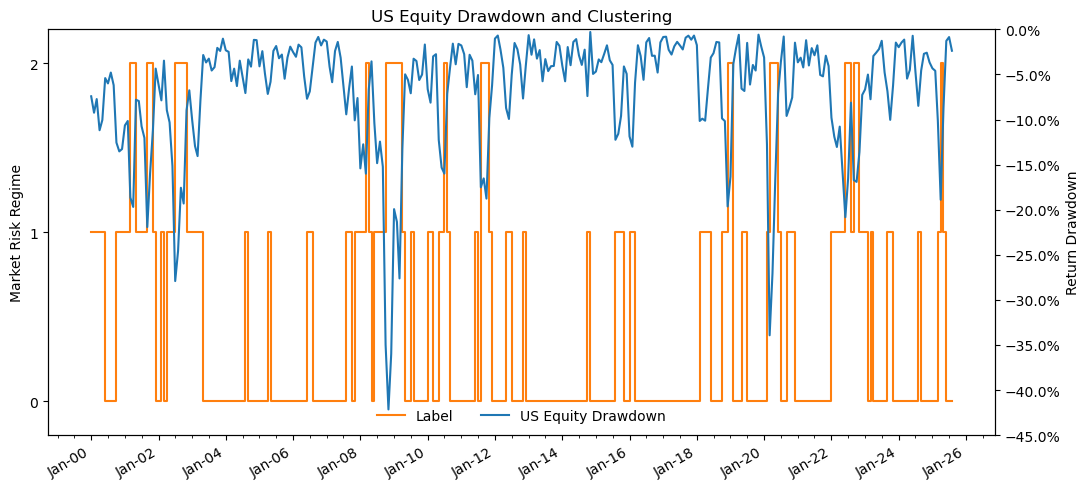

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# --- Align data (inner join on dates) ---
col = sp_3m_drawdown.columns[0]
df = (
    sp_3m_drawdown[[col]]
    .rename(columns={col: "drawdown"})
    .join(regimes[['regime']], how='inner')
    .dropna()
)

# --- Plot ---
fig, ax_left = plt.subplots(figsize=(11, 5))

# (1) Regime labels as a step plot on the LEFT y-axis (0/1/2)
ax_left.step(df.index, df['regime'], where='post', linewidth=1.5, color='tab:orange', label='Label')
ax_left.set_ylim(-0.2, 2.2)
ax_left.set_yticks([0, 1, 2])
ax_left.set_yticklabels(['0', '1', '2'])
ax_left.set_ylabel('Market Risk Regime')

# change the index of the x-axis
ax_left.xaxis.set_major_locator(YearLocator(2))
ax_left.xaxis.set_minor_locator(MonthLocator(bymonth=(1,7))) 
ax_left.xaxis.set_major_formatter(DateFormatter('%b-%y'))

# (2) Drawdown on the RIGHT y-axis (percent), often inverted (0% at top)
ax_right = ax_left.twinx()
ax_right.plot(df.index, df['drawdown'], linewidth=1.5, color='tab:blue', label='US Equity Drawdown')
ax_right.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax_right.set_ylabel('Return Drawdown')
# Optional: set a range like 0% to -45% and invert so 0% is at the top
lo = np.nanmin(df['drawdown'])
ax_right.set_ylim(0.0, min(-0.45, lo*1.05))  # cap around -45%
ax_right.invert_yaxis()

# Titles and legend
ax_left.set_title('US Equity Drawdown and Clustering')
ax_left.xaxis.set_major_formatter(DateFormatter('%b-%y'))
fig.autofmt_xdate()

# Build a single legend (take one handle from each axis)
h1, l1 = ax_left.get_legend_handles_labels()
h2, l2 = ax_right.get_legend_handles_labels()
ax_left.legend(h1 + h2, l1 + l2, loc='lower center', ncols=2, frameon=False)

plt.tight_layout()
plt.show()

In [34]:
stage01_component02_target = regimes[['regime']].copy()

In [35]:
exploratory_data_analysis_pd_dataframe(stage01_component02_target)

The shape:
(308, 1)

The number of na data:
Ticker
regime    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   regime  308 non-null    int64
dtypes: int64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
Ticker      regime
count   308.000000
mean      0.467532
std       0.662331
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       2.000000

The skewness of the input dataframe:
Ticker
regime    1.101646
dtype: float64

The kurtosis of the input dataframe:
Ticker
regime    0.009612
dtype: float64


### B - Input Features

Combine all features (1. Financial Turbulence; 2. Financial Condition; 3. Equity Valuation; 4. Monetary Policy Expectation)

In [59]:
stage01_component02_inputs = pd.concat([financial_turbulence, financial_condition, equity_valuation, monetary_policy_expectation], axis = 1)

In [37]:
exploratory_data_analysis_pd_dataframe(stage01_component02_inputs)

The shape:
(308, 7)

The number of na data:
financial_turbulence    0
nfc_risk                0
nfc_credit              0
nfc_leverage            0
TR CAPE                 0
effr                    0
t3m effr spread         0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   financial_turbulence  308 non-null    float64
 1   nfc_risk              308 non-null    float64
 2   nfc_credit            308 non-null    float64
 3   nfc_leverage          308 non-null    float64
 4   TR CAPE               308 non-null    float64
 5   effr                  308 non-null    float64
 6   t3m effr spread       308 non-null    float64
dtypes: float64(7)
memory usage: 19.2 KB
None

The numberic profile of the input data:
       financial_turbulence    nfc_risk  nfc_credit  nfc_l

In [61]:
stage01_component02_data = pd.concat([stage01_component02_inputs, sp_3m_drawdown, stage01_component02_target], axis = 1)
stage01_component02_data = stage01_component02_data.rename(columns={'^GSPC':'sp_3m_drawdown'})

In [62]:
stage01_component02_data

,financial_turbulence,nfc_risk,nfc_credit,nfc_leverage,TR CAPE,effr,t3m effr spread,sp_3m_drawdown,regime
2000-01-01,22.841091,-0.258570,0.058478,1.317603,47.587687,5.45,0.049000,-0.074249,1
2000-02-01,40.765253,-0.246968,0.025660,1.351058,45.807695,5.73,-0.003000,-0.092489,1
2000-03-01,24.338686,-0.155668,0.063858,1.181748,46.876009,5.85,0.013913,-0.077339,1
2000-04-01,17.526487,-0.033340,0.119385,0.876302,47.155407,6.02,-0.198421,-0.111885,1
2000-05-01,30.346658,0.061378,0.159085,0.602598,45.413038,6.27,-0.275455,-0.100559,1
...,...,...,...,...,...,...,...,...,...
2025-04-01,7.997325,-0.403042,0.017880,-0.419015,35.015341,4.33,-0.007619,-0.189022,2
2025-05-01,10.374252,-0.446606,-0.008484,-0.455824,37.637336,4.33,0.031429,-0.087890,1
2025-06-01,7.777932,-0.503590,-0.036160,-0.520180,38.732625,4.33,0.091000,-0.012807,0
2025-07-01,7.594025,-0.538555,-0.048125,-0.525730,40.137466,4.33,0.082273,-0.008573,0


In [88]:
stage01_component02_data.to_csv("stage01_component02_based_on_sp500_data.csv", index = True)
stage01_component02_data.to_excel("stage01_component02_based_on_sp500_data.xlsx", index = True)

### Extra Data for stage 02

#### Inflation

In [103]:
# Core CPI (CPI excluding food and energy)
core_cpi = fred.get_series('CPILFESL')  # Core CPI (Index, 1982-84=100) 

# 1-year annualized change
core_cpi_1y = core_cpi.pct_change(periods=12).dropna()

# 10-year annualized change (120 months)
core_cpi_10y = ((core_cpi / core_cpi.shift(120)) ** (1/10) - 1).dropna()

In [110]:
cpi_1y = core_cpi_1y.loc['2000-01-01':'2025-08-01']
cpi_10y = core_cpi_10y.loc['2000-01-01':'2025-08-01']

In [111]:
cpi_10y

2000-01-01    0.031022
2000-02-01    0.030612
2000-03-01    0.030337
2000-04-01    0.030123
2000-05-01    0.030044
                ...   
2025-04-01    0.030659
2025-05-01    0.030647
2025-06-01    0.030722
2025-07-01    0.030840
2025-08-01    0.031089
Length: 308, dtype: float64

#### GDP

In [104]:
real_gdp = fred.get_series('GDPC1')  # Real GDP (chained dollars)
real_gdp_growth_qoq = real_gdp.pct_change().dropna()  # quarter-over-quarter # might need to convert quarterly -> monthly by foreard filling the same value 
real_gdp_growth_yoy = real_gdp.pct_change(4).dropna() # year-over-year

In [112]:
real_gdp

1947-01-01     2182.681
1947-04-01     2176.892
1947-07-01     2172.432
1947-10-01     2206.452
1948-01-01     2239.682
                ...    
2024-04-01    23286.508
2024-07-01    23478.570
2024-10-01    23586.542
2025-01-01    23548.210
2025-04-01    23770.976
Length: 314, dtype: float64

In [115]:
real_gdp_change = real_gdp.diff()
real_gdp_monthly = real_gdp_change.resample('M').ffill()
real_gdp_monthly.index = real_gdp_monthly.index.to_period('M').to_timestamp('S')
real_gdp_growth = real_gdp_monthly.loc['2000-01-01':'2025-08-01']
print(real_gdp_growth.head(12))

2000-01-01     50.167
2000-02-01     50.167
2000-03-01     50.167
2000-04-01    252.761
2000-05-01    252.761
2000-06-01    252.761
2000-07-01     14.404
2000-08-01     14.404
2000-09-01     14.404
2000-10-01     84.453
2000-11-01     84.453
2000-12-01     84.453
Freq: MS, dtype: float64


In [131]:
real_gdp_growth.name = 'real_gdp_growth_monthly'
cpi_1y.name = 'cpi_1y'
cpi_10y.name = 'cpi_10y'

In [132]:
stage02_data = pd.concat([stage01_component02_data, real_gdp_growth, cpi_1y, cpi_10y], axis = 1)

In [133]:
stage02_data

,financial_turbulence,nfc_risk,nfc_credit,nfc_leverage,TR CAPE,effr,t3m effr spread,sp_3m_drawdown,regime,real_gdp_growth_monthly,cpi_1y,cpi_10y
2000-01-01,22.841091,-0.258570,0.058478,1.317603,47.587687,5.45,0.049000,-0.074249,1,50.167,0.021071,0.031022
2000-02-01,40.765253,-0.246968,0.025660,1.351058,45.807695,5.73,-0.003000,-0.092489,1,50.167,0.021640,0.030612
2000-03-01,24.338686,-0.155668,0.063858,1.181748,46.876009,5.85,0.013913,-0.077339,1,50.167,0.024474,0.030337
2000-04-01,17.526487,-0.033340,0.119385,0.876302,47.155407,6.02,-0.198421,-0.111885,1,252.761,0.022689,0.030123
2000-05-01,30.346658,0.061378,0.159085,0.602598,45.413038,6.27,-0.275455,-0.100559,1,252.761,0.023796,0.030044
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,7.997325,-0.403042,0.017880,-0.419015,35.015341,4.33,-0.007619,-0.189022,2,222.766,0.027815,0.030659
2025-05-01,10.374252,-0.446606,-0.008484,-0.455824,37.637336,4.33,0.031429,-0.087890,1,NaN,0.027671,0.030647
2025-06-01,7.777932,-0.503590,-0.036160,-0.520180,38.732625,4.33,0.091000,-0.012807,0,NaN,0.029079,0.030722
2025-07-01,7.594025,-0.538555,-0.048125,-0.525730,40.137466,4.33,0.082273,-0.008573,0,NaN,0.030486,0.030840


In [134]:
stage02_data.to_csv('stage02_data.csv', index = True)

In [135]:
stage02_data.to_excel('stage02_data.xlsx', index = True)

## S01C02: Stacking model to predict the market regime

In [40]:
# # pip install scikit-learn imbalanced-learn
# import pandas as pd
# import numpy as np

# from sklearn.model_selection import TimeSeriesSplit, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, log_loss
# from sklearn.ensemble import RandomForestClassifier, StackingClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE

# # ---- 1) Load your DataFrame (already created as stage01_component02_data) ----
# df = stage01_component02_data.copy()

# # ensure datetime index (optional but recommended)
# df.index = pd.to_datetime(df.index)

# # target and features
# y = df['regime'].astype(int)
# X = df.drop(columns=['regime'])

# # ---- 2) Define base learners + meta-learner (stacking) ----
# rf  = RandomForestClassifier(
#     n_estimators=400, max_depth=None, min_samples_leaf=2,
#     class_weight='balanced', random_state=42, n_jobs=-1
# )
# svc = SVC(kernel='rbf', C=3.0, gamma='scale',
#           class_weight='balanced', probability=True, random_state=42)
# gnb = GaussianNB()

# stack = StackingClassifier(
#     estimators=[('rf', rf), ('svc', svc), ('gnb', gnb)],
#     final_estimator=LogisticRegression(
#         max_iter=2000, multi_class='multinomial', solver='lbfgs'
#     ),
#     stack_method='predict_proba',
#     n_jobs=-1
# )

# # ---- 3) Build pipeline: scale -> SMOTE (train folds only) -> stacking ----
# pipe = Pipeline(steps=[
#     ('scaler', StandardScaler()),
#     ('smote',  SMOTE(random_state=42, k_neighbors=5)),
#     ('stack',  stack)
# ])

# # ---- 4) Time-series cross-validation (no leakage) ----
# tscv = TimeSeriesSplit(n_splits=5)
# cv_scores = cross_val_score(pipe, X, y, cv=tscv, scoring='neg_log_loss', n_jobs=-1)
# print('CV log loss (neg):', cv_scores)
# print('Mean log loss:', -cv_scores.mean())

# # ---- 5) Fit on train window and evaluate on a held-out tail (example: last 24 months) ----
# split_date = X.index.max() - pd.DateOffset(months=24)
# X_train, y_train = X.loc[:split_date], y.loc[:split_date]
# X_test,  y_test  = X.loc[split_date+pd.offsets.MonthBegin(1):], y.loc[split_date+pd.offsets.MonthBegin(1):]

# pipe.fit(X_train, y_train)
# proba = pipe.predict_proba(X_test)
# pred  = proba.argmax(axis=1)

# print(classification_report(y_test, pred, digits=3))
# print('Test log loss:', log_loss(y_test, proba))


### Base Model 01: Random Forest Wrong and Streamline Version

In [41]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# features and target 
df = stage01_component02_data.copy()
target_col = 'regime'
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

In [42]:
# chronological train/test split (last 20% as test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [43]:
# Class weights (helpful if since classes are imbalanced)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {c: w for c, w in zip(classes, weights)}

- `class_weight` works by adjusting each sample’s weight inside the loss function. In other words, it doesn’t change the model’s structure. Instead, it changes how important each sample is during training.

In [44]:
# Pipeline (imputer → RandomForest; scaling not required for RF)
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=300,        # defaults before tuning
        random_state=42,
        n_jobs=-1,
        class_weight=class_weight
    ))
])

In [45]:
# TimeSeries cross-validation + hyperparameter grid
tscv = TimeSeriesSplit(n_splits=5)

# can change laters
param_grid = {
    'rf__n_estimators': [150, 300, 600],
    'rf__max_depth'   : [4, 8, 12, 16, 24],
    'rf__min_samples_leaf': [1, 2, 3, 4, 5],
    'rf__max_features': ['sqrt', 'log2'], # Controls how many features the Random Forest considers when splitting each node
    'rf__bootstrap'   : [True] # more randomness, often better generalization 
}

`rf__max_features`: Controls how many features the Random Forest considers when splitting each node. In Random Forests, each tree doesn’t see all features at every split — it randomly samples a subset. This helps trees become less correlated and the ensemble more robust.

| Value                  | Meaning                      | Intuition                                   |
| :--------------------- | :--------------------------- | :------------------------------------------ |
| `'sqrt'`               | use √(number of features)    | default for classification                  |
| `'log2'`               | use log₂(number of features) | smaller subset = more randomness            |
| `None` or `n_features` | use all features             | less randomness, higher risk of overfitting |


In [46]:
# train model and find the best parameter
gcv = GridSearchCV( 
    # gcv is a `GridSearchCV` object that contains the pipeline 
    # which itself contain the Random Forest object.
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1_macro',   # macro F1 is robust to class imbalance
    n_jobs=-1,
    refit=True,
    verbose=0
)

gcv.fit(X_train, y_train)

print("Best CV params:", gcv.best_params_)
print("Best CV f1_macro:", gcv.best_score_)

Best CV params: {'rf__bootstrap': True, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 600}
Best CV f1_macro: 0.9685019206145966


In [47]:
# Test-set evaluation using the best parameter
best_model = gcv.best_estimator_
y_pred = best_model.predict(X_test)
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


Test Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        39
           1      1.000     0.944     0.971        18
           2      0.833     1.000     0.909         5

    accuracy                          0.984        62
   macro avg      0.944     0.981     0.960        62
weighted avg      0.987     0.984     0.984        62



| **Metric** | **Definition / Intuition** | **Mathematical Expression** |
|:--|:--|:--|
| **Precision** | Of all samples predicted as this class, how many are actually correct | $$\text{Precision} = \frac{TP}{TP + FP}$$ |
| **Recall** | Of all samples that truly belong to this class, how many are successfully detected | $$\text{Recall} = \frac{TP}{TP + FN}$$ |
| **F1-score** | Harmonic mean of precision and recall; balances both | $$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$ |
| **Support** | Number of true samples of this class in the dataset | $$\text{Support} = N_{\text{samples of class}}$$ |
| **Accuracy** | Overall proportion of correct predictions | $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$ |
| **Macro Avg** | Simple mean across all classes (treats each class equally) | $$\text{Macro Avg} = \frac{1}{K}\sum_{i=1}^{K} M_i$$ |
| **Weighted Avg** | Mean weighted by the number of samples (support) per class | $$\text{Weighted Avg} = \frac{\sum_{i=1}^{K} w_i M_i}{\sum_{i=1}^{K} w_i}, \quad w_i = \text{support}_i$$ |

- where T/F means True/False, and P/N means Positive/Negeative 

In [48]:
# !!!!!! the outcome (predict result is too good to be true)
# multiclass ROC-AUC using predict_proba (OvR)
if hasattr(best_model.named_steps['rf'], "predict_proba"):
    y_proba = best_model.predict_proba(X_test)
    # One-vs-Rest ROC AUC (needs label-binarized y)
    y_bin = pd.get_dummies(y_test, columns=classes).values
    auc = roc_auc_score(y_bin, y_proba, multi_class='ovr')
    print("Test ROC-AUC (OvR):", round(auc, 3))

Test ROC-AUC (OvR): 0.998


In multiclass classification (3 or more classes), ROC curves become multi-dimensional. So yes, it’s more complex than the simple binary case, so the AI just recommend the  multiclass ROC-AUC using predict_proba (OvR) which is a single number instead.

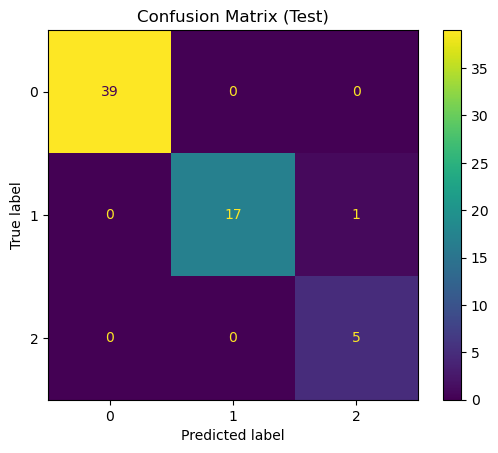

In [49]:
# Confusion matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title("Confusion Matrix (Test)")
plt.show()

In [50]:
# Feature importance (impurity-based)
rf = best_model.named_steps['rf']
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nGini Importances (top 10):")
print(importances.head(10))


Gini Importances (top 10):
^GSPC                   0.644762
nfc_credit              0.122951
nfc_risk                0.056834
financial_turbulence    0.050407
TR CAPE                 0.041006
nfc_leverage            0.035081
effr                    0.031444
t3m effr spread         0.017515
dtype: float64



Permutation Importances (top 10):
^GSPC                   0.508065
financial_turbulence    0.000000
nfc_risk                0.000000
nfc_credit              0.000000
nfc_leverage            0.000000
TR CAPE                 0.000000
effr                    0.000000
t3m effr spread         0.000000
dtype: float64


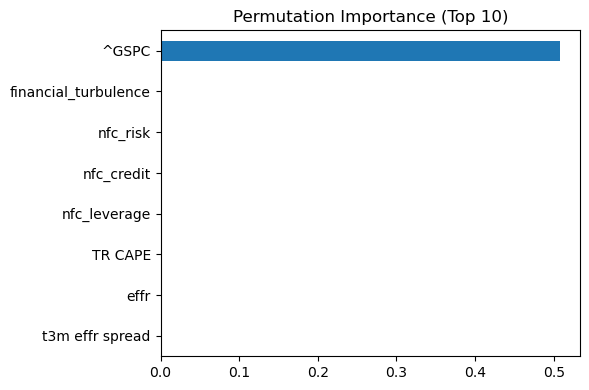

In [51]:
# Permutation importance (test set; more reliable)
perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("\nPermutation Importances (top 10):")
print(perm_importances.head(10))

# Quick plot for permutation importance
perm_importances.head(10).iloc[::-1].plot(kind='barh', figsize=(6,4))
plt.title("Permutation Importance (Top 10)")
plt.tight_layout()
plt.show()

- So here the outcome is quite obvious, `we definitely should drop the sp_3m_drawdown feature, or at least shift it`.

### Base Model 01: Random Forest Encapsulate Version

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance


def train_rf_regime_classifier(
    df: pd.DataFrame,
    target_col: str = "regime",
    test_size: float = 0.2,
    n_splits: int = 5,
    scoring: str = "f1_macro",
    tune: bool = True,
    param_grid: dict | None = None,
    random_state: int = 42,
    plot: bool = True
) -> dict:
    """
    Train a time-series-safe Random Forest classifier to predict `target_col` (e.g., 3-class regime).

    Steps:
      - Sort by index (assumes DateTimeIndex)
      - Forward/backward fill missing values, drop remaining NA rows
      - Chronological split (last `test_size` fraction as test)
      - Class weights for imbalance
      - Pipeline: Imputer -> RandomForest
      - Optional hyperparameter tuning via GridSearchCV with TimeSeriesSplit
      - Evaluation on test set + feature importances and permutation importances

    Returns a dict with fitted objects and key artifacts.
    """
    # ---- 1) Sort and split X/y ----
    df = df.sort_index()
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)

    # ---- 2) Basic NA handling ----
    X = X.ffill().bfill()
    mask = ~X.isna().any(axis=1)
    X, y = X.loc[mask], y.loc[mask]

    # ---- 3) Chronological split ----
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # ---- 4) Class weights (balanced) ----
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight = {c: w for c, w in zip(classes, weights)}

    # ---- 5) Pipeline ----
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestClassifier(
            n_estimators=300,
            random_state=random_state,
            n_jobs=-1,
            class_weight=class_weight
        ))
    ])

    # ---- 6) Tuning setup ----
    if param_grid is None:
        param_grid = {
            'rf__n_estimators': [150, 300, 600],
            'rf__max_depth'   : [4, 8, 12, 16, 24],
            'rf__min_samples_leaf': [1, 2, 3, 4, 5],
            'rf__max_features': ['sqrt', 'log2'], # Controls how many features the Random Forest considers when splitting each node
            'rf__bootstrap'   : [True] # more randomness, often better generalization 
        }

    tscv = TimeSeriesSplit(n_splits=n_splits)

    if tune:
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            n_jobs=-1,
            refit=True,
            verbose=0
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        best_params = search.best_params_
        best_cv_score = search.best_score_
    else:
        model = pipe.fit(X_train, y_train)
        best_params = {}
        best_cv_score = None

    # ---- 7) Evaluation on test ----
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    auc_ovr = None
    y_proba = None
    rf = model.named_steps['rf']
    if hasattr(rf, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        # binarize y for multiclass AUC
        y_bin = pd.get_dummies(y_test, columns=classes).reindex(columns=classes, fill_value=0).values
        # reorder columns of y_proba to match 'classes' order used above
        # (sklearn ensures estimator.classes_ order)
        proba_reordered = y_proba[:, np.searchsorted(rf.classes_, classes)]
        auc_ovr = roc_auc_score(y_bin, proba_reordered, multi_class='ovr')

    # ---- 8) Importances ----
    gini_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

    perm = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=random_state, n_jobs=-1)
    perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

    # ---- 9) Optional plots ----
    if plot:
        fig, ax = plt.subplots()
        ConfusionMatrixDisplay(cm).plot(ax=ax)
        ax.set_title("Confusion Matrix (Test)")
        plt.tight_layout()
        plt.show()

        perm_importances.head(10).iloc[::-1].plot(kind='barh', figsize=(6, 4))
        plt.title("Permutation Importance (Top 10)")
        plt.tight_layout()
        plt.show()

    # ---- 10) Package results ----
    return {
        "model": model,
        "best_params": best_params,
        "best_cv_score": best_cv_score,
        "y_pred": y_pred,
        "y_test": y_test,
        "y_proba": y_proba,
        "report_dict": report,
        "confusion_matrix": cm,
        "gini_importances": gini_importances,
        "perm_importances": perm_importances,
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test_series": y_test,  # y_test also returned above
        "classes": classes
    }

**Trial One**: 

Drop the max drawdown data, cause the last case (the feature importance step) have show that should omitted, or at least been shifted

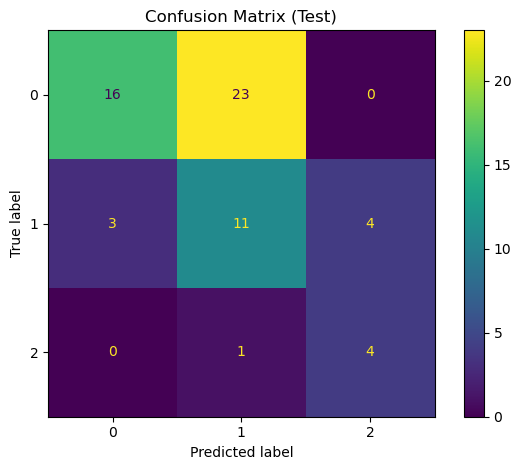

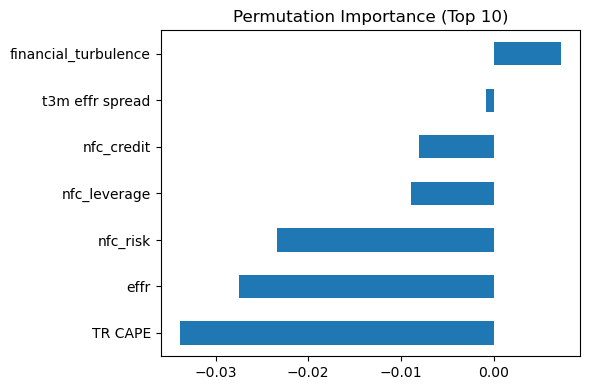

Best params: {'rf__bootstrap': True, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 300}
Best CV score (f1_macro): 0.38331294049177467
           precision    recall  f1-score  support
0           0.842105  0.410256  0.551724     39.0
1           0.314286  0.611111  0.415094     18.0
2           0.500000  0.800000  0.615385      5.0
accuracy    0.500000  0.500000  0.500000      0.5
macro avg   0.552130  0.607123  0.527401     62.0
Top Gini importances:
 nfc_credit              0.217505
nfc_risk                0.161546
financial_turbulence    0.143990
TR CAPE                 0.143929
nfc_leverage            0.129443
effr                    0.119233
t3m effr spread         0.084355
dtype: float64
Top Permutation importances:
 financial_turbulence    0.007258
t3m effr spread        -0.000806
nfc_credit             -0.008065
nfc_leverage           -0.008871
nfc_risk               -0.023387
effr                   -0.027419
TR CAPE             

In [65]:
# Sample use (drop the max drawdown data, cause the last case (the feature importance step) have show that should omitted, or at least been shifted)
df = stage01_component02_data.drop(columns=['sp_3m_drawdown'])
res = train_rf_regime_classifier(df, target_col="regime", test_size=0.2, n_splits=5, tune=True, plot=True)
print("Best params:", res["best_params"])
print("Best CV score (f1_macro):", res["best_cv_score"])
print(pd.DataFrame(res["report_dict"]).T.head())
print("Top Gini importances:\n", res["gini_importances"].head(10))
print("Top Permutation importances:\n", res["perm_importances"].head(10))


**Trial Two:**

Shift the sp maxdrawdown data by one to prevent future info leakage as shown by the former case.

As we can see, the outcome is much better, but it is still quite hard to tell the correction regime and the bear regime(so in the trial three, I gonna merge these two index, since in the stage 2 they are also the same (merged by the original paper author))

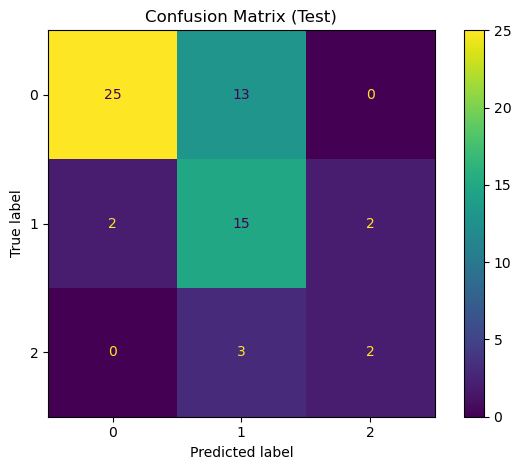

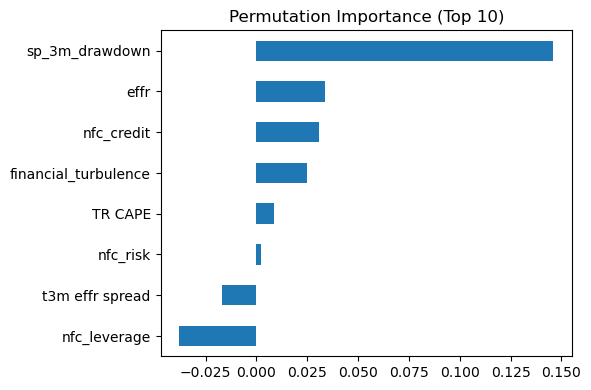

Best params: {'rf__bootstrap': True, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 150}
Best CV score (f1_macro): 0.5925929390061047
           precision    recall  f1-score    support
0           0.925926  0.657895  0.769231  38.000000
1           0.483871  0.789474  0.600000  19.000000
2           0.500000  0.400000  0.444444   5.000000
accuracy    0.677419  0.677419  0.677419   0.677419
macro avg   0.636599  0.615789  0.604558  62.000000
Top Gini importances:
 sp_3m_drawdown          0.301367
nfc_credit              0.252152
effr                    0.081497
financial_turbulence    0.081416
nfc_leverage            0.079341
TR CAPE                 0.071375
nfc_risk                0.070756
t3m effr spread         0.062097
dtype: float64
Top Permutation importances:
 sp_3m_drawdown          0.145968
effr                    0.033871
nfc_credit              0.030645
financial_turbulence    0.025000
TR CAPE                 0.008871
nfc_risk 

In [66]:
# shift the sp maxdrawdown data by one to prevent future info leakage as shown by the former case
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# use the encapsulated model 
res = train_rf_regime_classifier(df, target_col="regime", test_size=0.2, n_splits=5, tune=True, plot=True)
print("Best params:", res["best_params"])
print("Best CV score (f1_macro):", res["best_cv_score"])
print(pd.DataFrame(res["report_dict"]).T.head())
print("Top Gini importances:\n", res["gini_importances"].head(10))
print("Top Permutation importances:\n", res["perm_importances"].head(10))


**Trial Three:**

Based on the trial 2 (shift the sp drawdown data), this time I gonna merge these two index, since in the stage 2 they are also the same (merged by the original paper author)

In [67]:
# shift the sp maxdrawdown data by one to prevent future info leakage as shown by the former case
df = stage01_component02_data.copy()
df['sp_3m_drawdown'] = df['sp_3m_drawdown'].shift(-1) 
df = df.dropna() # 307 * 9

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

In [68]:
df['regime'].value_counts() # the out

regime
0    192
1    115
Name: count, dtype: int64

In [69]:
stage01_component02_data['regime'].value_counts()

regime
0    193
1     86
2     29
Name: count, dtype: int64

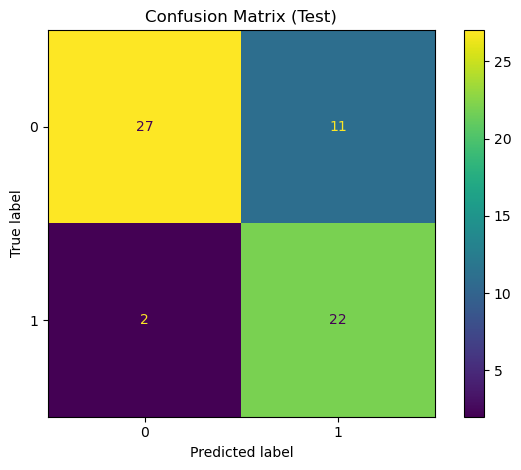

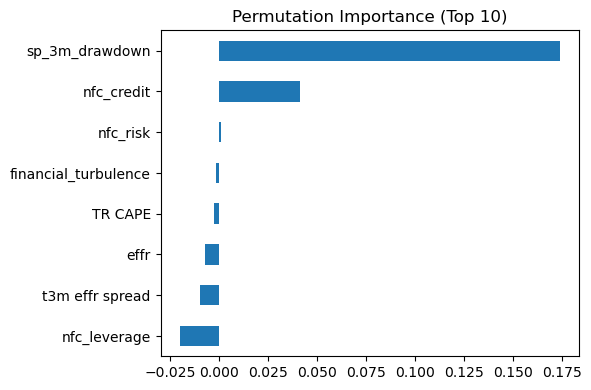

Best params: {'rf__bootstrap': True, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 150}
Best CV score (f1_macro): 0.7281408796402982
              precision    recall  f1-score    support
0              0.931034  0.710526  0.805970  38.000000
1              0.666667  0.916667  0.771930  24.000000
accuracy       0.790323  0.790323  0.790323   0.790323
macro avg      0.798851  0.813596  0.788950  62.000000
weighted avg   0.828699  0.790323  0.792793  62.000000
Top Gini importances:
 sp_3m_drawdown          0.270252
nfc_credit              0.265591
financial_turbulence    0.112698
nfc_risk                0.096469
nfc_leverage            0.092609
TR CAPE                 0.066022
effr                    0.054134
t3m effr spread         0.042226
dtype: float64
Top Permutation importances:
 sp_3m_drawdown          0.174194
nfc_credit              0.041129
nfc_risk                0.000806
financial_turbulence   -0.001613
TR CAPE                -

In [70]:
# use the encapsulated model 
res = train_rf_regime_classifier(df, target_col="regime", test_size=0.2, n_splits=5, tune=True, plot=True)
print("Best params:", res["best_params"])
print("Best CV score (f1_macro):", res["best_cv_score"])
print(pd.DataFrame(res["report_dict"]).T.head())
print("Top Gini importances:\n", res["gini_importances"].head(10))
print("Top Permutation importances:\n", res["perm_importances"].head(10))

**Trial Four:**

This time the combination is: drop sp_max_drawdown and merge the correction and bear regiem.

In [71]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df = df.drop(columns=['sp_3m_drawdown'])

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

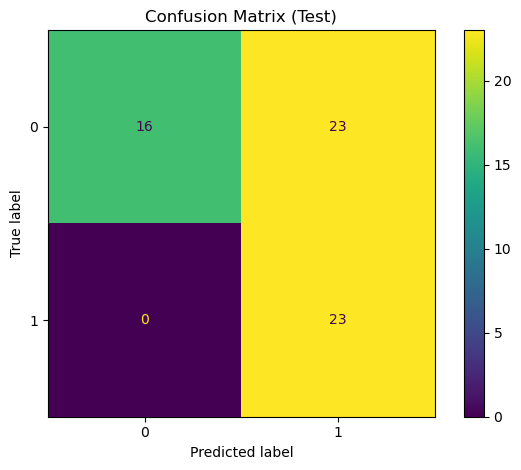

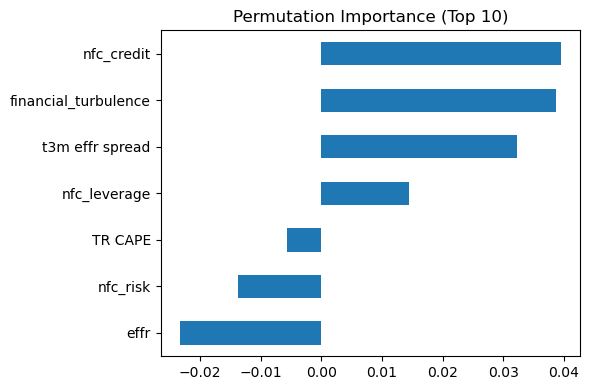

Best params: {'rf__bootstrap': True, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 600}
Best CV score (f1_macro): 0.6201454109089715
              precision    recall  f1-score    support
0              1.000000  0.410256  0.581818  39.000000
1              0.500000  1.000000  0.666667  23.000000
accuracy       0.629032  0.629032  0.629032   0.629032
macro avg      0.750000  0.705128  0.624242  62.000000
weighted avg   0.814516  0.629032  0.613294  62.000000
Top Gini importances:
 nfc_credit              0.289087
financial_turbulence    0.187126
nfc_risk                0.165372
nfc_leverage            0.135966
TR CAPE                 0.093712
effr                    0.076391
t3m effr spread         0.052346
dtype: float64
Top Permutation importances:
 nfc_credit              0.039516
financial_turbulence    0.038710
t3m effr spread         0.032258
nfc_leverage            0.014516
TR CAPE                -0.005645
nfc_risk               -

In [72]:
# use the encapsulated model 
res = train_rf_regime_classifier(df, target_col="regime", test_size=0.2, n_splits=5, tune=True, plot=True)
print("Best params:", res["best_params"])
print("Best CV score (f1_macro):", res["best_cv_score"])
print(pd.DataFrame(res["report_dict"]).T.head())
print("Top Gini importances:\n", res["gini_importances"].head(10))
print("Top Permutation importances:\n", res["perm_importances"].head(10))

**Trial Five:**

1. All stay the same, move the target (market regime) one step to prevent potential future info leakage.

2. Merge the correction and bear market regime

In [73]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

In [74]:
df

,financial_turbulence,nfc_risk,nfc_credit,nfc_leverage,TR CAPE,effr,t3m effr spread,sp_3m_drawdown,regime
2000-02-01,40.765253,-0.246968,0.025660,1.351058,45.807695,5.73,-0.003000,-0.092489,1.0
2000-03-01,24.338686,-0.155668,0.063858,1.181748,46.876009,5.85,0.013913,-0.077339,1.0
2000-04-01,17.526487,-0.033340,0.119385,0.876302,47.155407,6.02,-0.198421,-0.111885,1.0
2000-05-01,30.346658,0.061378,0.159085,0.602598,45.413038,6.27,-0.275455,-0.100559,1.0
2000-06-01,40.564687,0.068576,0.203618,0.356044,46.245587,6.53,-0.668182,-0.054060,1.0
...,...,...,...,...,...,...,...,...,...
2025-04-01,7.997325,-0.403042,0.017880,-0.419015,35.015341,4.33,-0.007619,-0.189022,1.0
2025-05-01,10.374252,-0.446606,-0.008484,-0.455824,37.637336,4.33,0.031429,-0.087890,1.0
2025-06-01,7.777932,-0.503590,-0.036160,-0.520180,38.732625,4.33,0.091000,-0.012807,1.0
2025-07-01,7.594025,-0.538555,-0.048125,-0.525730,40.137466,4.33,0.082273,-0.008573,0.0


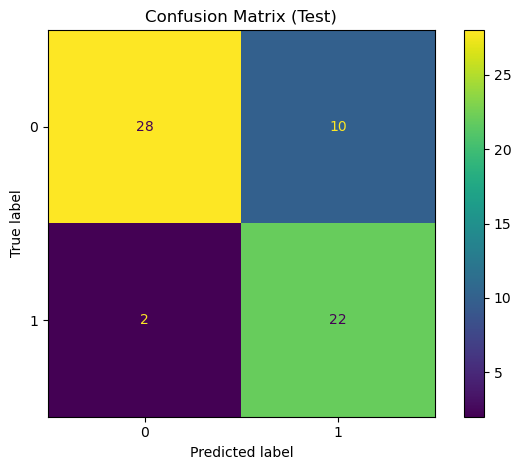

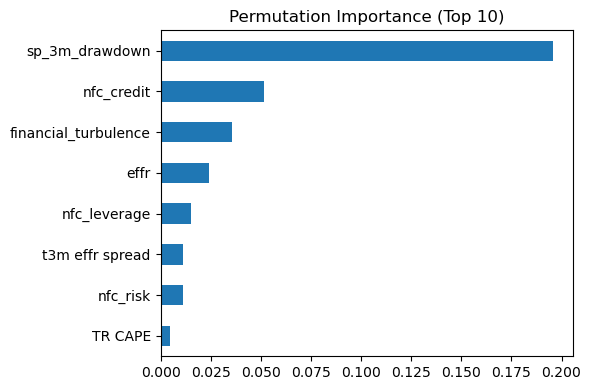

Best params: {'rf__bootstrap': True, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 600}
Best CV score (f1_macro): 0.7079636560895931
              precision    recall  f1-score    support
0              0.933333  0.736842  0.823529  38.000000
1              0.687500  0.916667  0.785714  24.000000
accuracy       0.806452  0.806452  0.806452   0.806452
macro avg      0.810417  0.826754  0.804622  62.000000
weighted avg   0.838172  0.806452  0.808891  62.000000
Top Gini importances:
 sp_3m_drawdown          0.276445
nfc_credit              0.265394
nfc_risk                0.108076
financial_turbulence    0.105233
nfc_leverage            0.089422
TR CAPE                 0.060869
t3m effr spread         0.049023
effr                    0.045538
dtype: float64
Top Permutation importances:
 sp_3m_drawdown          0.195968
nfc_credit              0.051613
financial_turbulence    0.035484
effr                    0.024194
nfc_leverage            

In [75]:
# use the encapsulated model 
res = train_rf_regime_classifier(df, target_col="regime", test_size=0.2, n_splits=5, tune=True, plot=True)
print("Best params:", res["best_params"])
print("Best CV score (f1_macro):", res["best_cv_score"])
print(pd.DataFrame(res["report_dict"]).T.head())
print("Top Gini importances:\n", res["gini_importances"].head(10))
print("Top Permutation importances:\n", res["perm_importances"].head(10))

attention the confusion matrix is based on the test data

In [78]:
y_full_pred = res['model'].predict(df.drop(columns= ['regime']))

In [80]:
# Generate a monthly date index starting from 2000-03-01
date_index = pd.date_range(start="2000-03-01", periods=len(y_full_pred), freq="MS")

# Create a Pandas Series
y_pred_series = pd.Series(y_full_pred, index=date_index, name="regime_pred")


In [82]:
type(y_pred_series)

pandas.core.series.Series

In [83]:
y_pred_series.to_csv("regime_prediction_RF_single_base_model.csv", index = True)

In [85]:
y_pred_series.to_excel("regime_prediction_RF_single_base_model.xlsx", index = True)

### Base Model 02: Gaussian Naive Bayes (no func versoin)

In [89]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

Best params: {'gnb__priors': None, 'gnb__var_smoothing': np.float64(1e-12)}
Best CV score (F1): 0.33964912280701753

Classification report (test):
              precision    recall  f1-score   support

           0      0.708     0.895     0.791        38
           1      0.714     0.417     0.526        24

    accuracy                          0.710        62
   macro avg      0.711     0.656     0.659        62
weighted avg      0.711     0.710     0.688        62



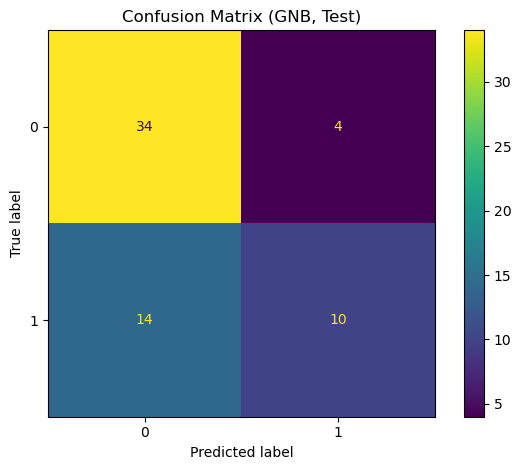

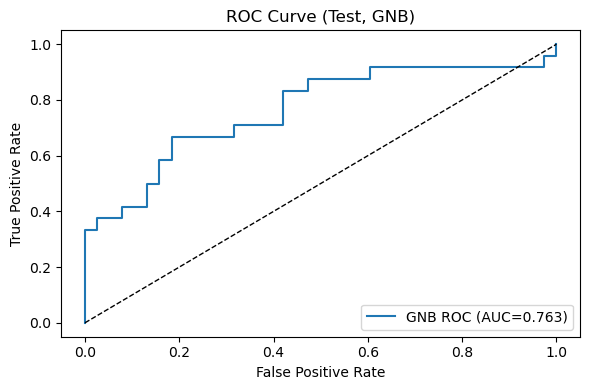

In [90]:
# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    ConfusionMatrixDisplay
)

# 1) Assume your DataFrame is called df and has a DateTimeIndex
#    Columns: features + 'regime' (binary target)
df = df.sort_index()

# 2) Features / target
X = df.drop(columns=['regime'])
y = df['regime'].astype(int)

# (If your data accidentally has a '2' value, force binary as you stated.)
# y = y.replace({2: 1})  # uncomment if needed

# # 3) Simple NA handling (forward/back fill; drop remaining NA rows)
# X = X.ffill().bfill()
# mask = ~X.isna().any(axis=1)
# X, y = X.loc[mask], y.loc[mask]

# 4) Chronological train/test split (last 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 5) Pipeline: Imputer -> GaussianNB
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('gnb', GaussianNB())
])

# 6) HYPERPARAMETERS (for GridSearchCV)
#    GaussianNB main tunable hyperparameters in sklearn:
#      - var_smoothing: stability added to variances (default 1e-9)
#      - priors: class priors (None = learned from data; or you can set [p0, p1])
param_grid = {
    'gnb__var_smoothing': np.logspace(-12, -6, 7),   # <-- HYPERPARAMETER
    'gnb__priors': [None, [0.5, 0.5]]                # <-- HYPERPARAMETER (optional)
}

tscv = TimeSeriesSplit(n_splits=5)

gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1',            # binary F1 (you could use 'roc_auc' as well)
    n_jobs=-1,
    refit=True,
    verbose=0
)

# 7) Train (fit) with time-series CV
gcv.fit(X_train, y_train)
print("Best params:", gcv.best_params_)
print("Best CV score (F1):", gcv.best_score_)

# 8) Evaluate on test
best_model = gcv.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # probability of class '1'

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title("Confusion Matrix (GNB, Test)")
plt.tight_layout()
plt.show()

# 9) ROC curve (binary)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'GNB ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test, GNB)')
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# 10) If you want FULL predictions over the whole dataset (optional):
y_full_pred = best_model.predict(X)
y_full_prob = best_model.predict_proba(X)[:, 1]
# Attach to a DataFrame with your monthly index if desired:
gnb_pred_df = pd.DataFrame({
    'regime_actual': y,
    'regime_pred': y_full_pred,
    'regime_prob1': y_full_prob
}, index=X.index)


### Base Model 02: Gaussian Naive Bayes (encapsulated func versoin)

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    ConfusionMatrixDisplay
)

def train_gnb_regime_classifier(
    df: pd.DataFrame,
    target_col: str = "regime",
    test_size: float = 0.2,
    n_splits: int = 5,
    scoring: str = "f1",          # binary F1; change to 'roc_auc' if preferred
    tune: bool = True,
    param_grid: dict | None = None,
    plot: bool = True
) -> dict:
    """
    Time-series-safe Gaussian Naive Bayes to predict a binary `regime`.

    Pipeline: Imputer(median) -> GaussianNB
    Hyperparameters for tuning (in param_grid):
      - gnb__var_smoothing : float (stability added to variances; default 1e-9)
      - gnb__priors        : list or None (class priors, e.g., [0.5, 0.5])
    """
    # ---- 1) Order & split ----
    df = df.sort_index()
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)  # assumes {0,1}

    # # ---- 2) Basic NA handling ----
    # X = X.ffill().bfill()
    # mask = ~X.isna().any(axis=1)
    # X, y = X.loc[mask], y.loc[mask]

    # ---- 3) Chronological split ----
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # ---- 4) Pipeline ----
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('gnb', GaussianNB())
    ])

    # ---- 5) Hyperparameter grid ----
    if param_grid is None:
        param_grid = {
            'gnb__var_smoothing': np.logspace(-12, -6, 7),  # <-- main hyperparameter
            'gnb__priors': [None, [0.5, 0.5]]               # optional: set equal priors
        }

    tscv = TimeSeriesSplit(n_splits=n_splits)

    # ---- 6) Fit (with or without tuning) ----
    if tune:
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            n_jobs=-1,
            refit=True,
            verbose=0
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        best_params = search.best_params_
        best_cv_score = search.best_score_
    else:
        model = pipe.fit(X_train, y_train)
        best_params = {}
        best_cv_score = None

    # ---- 7) Test evaluation ----
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    if plot:
        fig, ax = plt.subplots()
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
        ax.set_title("Confusion Matrix (GNB, Test)")
        plt.tight_layout(); plt.show()

        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'GNB ROC (AUC={roc_auc:.3f})')
        plt.plot([0,1],[0,1],'k--', lw=1)
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (Test, GNB)')
        plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

    # ---- 8) (Optional) full-sample predictions ----
    y_full_pred = model.predict(X)
    y_full_prob = model.predict_proba(X)[:, 1]

    # ---- 9) Return artifacts ----
    return {
        "model": model,
        "best_params": best_params,
        "best_cv_score": best_cv_score,
        "y_pred": y_pred,           # test labels
        "y_prob": y_prob,           # test prob for class 1
        "y_test": y_test,
        "roc_auc": roc_auc,
        "fpr": fpr, "tpr": tpr,
        "confusion_matrix": cm,
        "report_dict": report,
        "y_full_pred": y_full_pred, # full-sample labels
        "y_full_prob": y_full_prob, # full-sample prob for class 1
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test_series": y_test
    }


In [94]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

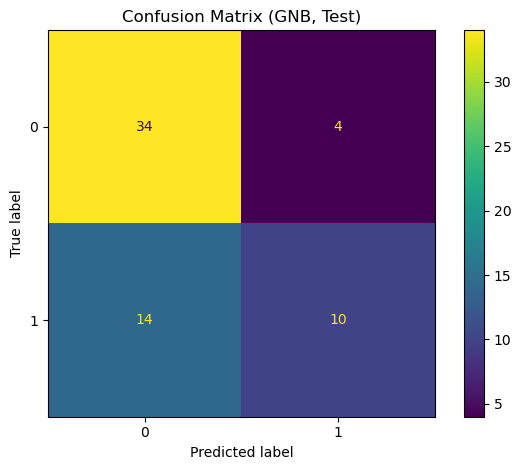

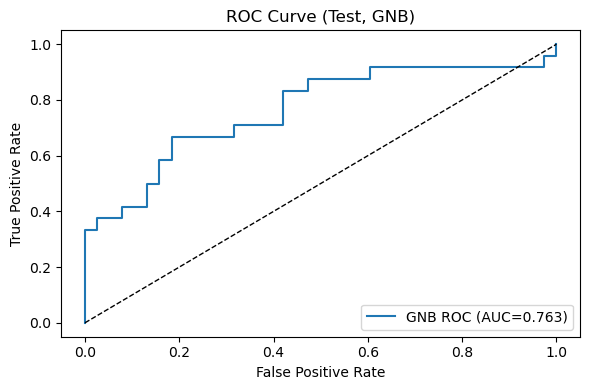

Best params: {'gnb__priors': None, 'gnb__var_smoothing': np.float64(1e-12)}
Best CV score: 0.33964912280701753
              precision    recall  f1-score    support
0              0.708333  0.894737  0.790698  38.000000
1              0.714286  0.416667  0.526316  24.000000
accuracy       0.709677  0.709677  0.709677   0.709677
macro avg      0.711310  0.655702  0.658507  62.000000
weighted avg   0.710637  0.709677  0.688356  62.000000


In [95]:
res = train_gnb_regime_classifier(df, target_col="regime", tune=True, plot=True)
print("Best params:", res["best_params"])
print("Best CV score:", res["best_cv_score"])
print(pd.DataFrame(res["report_dict"]).T.head())


### Base Model 03: Supported Vector Classifier (no func version)

In [96]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

Best params: {'svc__C': 5, 'svc__kernel': 'linear'}
Best CV score: 0.5970899276162435

Classification report (test):
              precision    recall  f1-score   support

           0      0.882     0.789     0.833        38
           1      0.714     0.833     0.769        24

    accuracy                          0.806        62
   macro avg      0.798     0.811     0.801        62
weighted avg      0.817     0.806     0.809        62



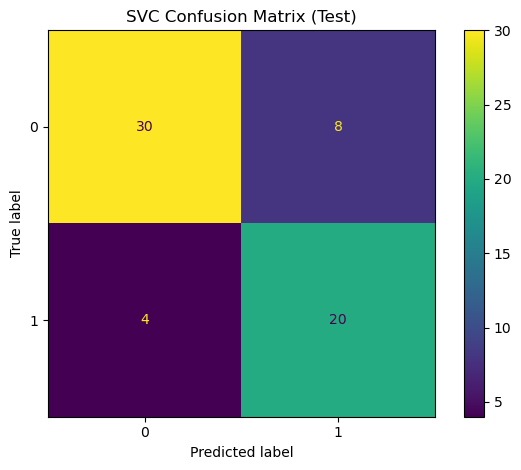

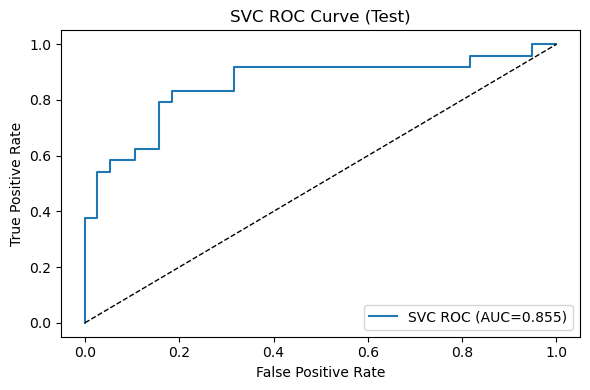

,regime_actual,regime_pred,regime_prob1
2000-02-01,1,1,0.587902
2000-03-01,1,1,0.460127
2000-04-01,1,1,0.629937
2000-05-01,1,1,0.678808
2000-06-01,1,1,0.514477


In [97]:
# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    ConfusionMatrixDisplay
)

X = df.drop(columns=['regime'])
y = df['regime'].astype(int)

# If your series occasionally has '2' but you want strictly binary {0,1}, coerce here:
# y = y.replace({2: 1})

# 2) Basic NA handling (forward/back fill then drop any remaining NaNs)
# X = X.ffill().bfill()
# mask = ~X.isna().any(axis=1)
# X, y = X.loc[mask], y.loc[mask]

# 3) Chronological split (last 20% as test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4) Build the pipeline:
#    Imputer -> StandardScaler (SVM needs scaling) -> SVC (with probability=True for ROC/stacking)
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('svc', SVC(probability=True, class_weight='balanced', random_state=42))
])

# 5) HYPERPARAMETERS (kernel trick + soft margin + others)
#    - kernel: 'linear', 'rbf', 'poly', 'sigmoid'
#    - C: soft-margin penalty (larger C = less regularization, harder margin)
#    - gamma: kernel width for rbf/poly/sigmoid ('scale','auto', or float)
#    - degree: only used by 'poly'
#    - coef0: affects 'poly' and 'sigmoid'
param_grid = [
    # Linear kernel (gamma ignored)
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 5, 10]
    },
    # RBF kernel
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 5, 10],
        'svc__gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
    },
    # Polynomial kernel
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 5],
        'svc__gamma': ['scale', 'auto', 0.1, 0.01],
        'svc__degree': [2, 3, 4],
        'svc__coef0': [0.0, 0.5, 1.0]
    },
    # Sigmoid kernel
    {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.1, 1, 5, 10],
        'svc__gamma': ['scale', 'auto', 0.1, 0.01],
        'svc__coef0': [0.0, 0.5, 1.0]
    }
]

tscv = TimeSeriesSplit(n_splits=5)

gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1',        # for binary; you can switch to 'roc_auc'
    n_jobs=-1,
    refit=True,
    verbose=0
)

# 6) Fit with time-series CV; pick the best combo
gcv.fit(X_train, y_train)
print("Best params:", gcv.best_params_)
print("Best CV score:", gcv.best_score_)

best_model = gcv.best_estimator_

# 7) Evaluate on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # prob of class 1

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=3))

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title("SVC Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

# 8) ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'SVC ROC (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve (Test)')
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# 9) (Optional) Full-sample predictions for plotting/backtesting/stacking
y_full_pred = best_model.predict(X)
y_full_prob = best_model.predict_proba(X)[:, 1]

svc_pred_df = pd.DataFrame({
    'regime_actual': y,
    'regime_pred': y_full_pred,
    'regime_prob1': y_full_prob
}, index=X.index)
svc_pred_df.head()


### Base Model 03: Support Vector Classifier (encapsulate func version)

In [98]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    ConfusionMatrixDisplay
)

def train_svc_regime_classifier(
    df: pd.DataFrame,
    target_col: str = "regime",
    test_size: float = 0.2,
    n_splits: int = 5,
    scoring: str = "f1",            # or 'roc_auc'
    tune: bool = True,
    param_grid: dict | None = None,
    plot: bool = True,
    random_state: int = 42
) -> dict:
    """
    Time-series-safe SVC (with scaling) to predict binary `regime`.
    Tuning covers kernel trick (linear/rbf/poly/sigmoid), soft margin C, gamma, degree, coef0.
    """
    # ---- 1) Order & define X/y ----
    df = df.sort_index()
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)   # expects {0,1}

    # # ---- 2) NA handling ----
    # X = X.ffill().bfill()
    # mask = ~X.isna().any(axis=1)
    # X, y = X.loc[mask], y.loc[mask]

    # ---- 3) Chronological split ----
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # ---- 4) Pipeline: Imputer -> Scaler -> SVC ----
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('svc', SVC(probability=True, class_weight='balanced', random_state=random_state))
    ])

    # ---- 5) Hyperparameter grid (kernel + soft margin + others) ----
    if param_grid is None:
        param_grid = [
            {   # linear kernel (soft margin C)
                'svc__kernel': ['linear'],
                'svc__C': [0.1, 1, 5, 10]
            },
            {   # rbf kernel
                'svc__kernel': ['rbf'],
                'svc__C': [0.1, 1, 5, 10],
                'svc__gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
            },
            {   # polynomial kernel
                'svc__kernel': ['poly'],
                'svc__C': [0.1, 1, 5],
                'svc__gamma': ['scale', 'auto', 0.1, 0.01],
                'svc__degree': [2, 3, 4],
                'svc__coef0': [0.0, 0.5, 1.0]
            },
            {   # sigmoid kernel
                'svc__kernel': ['sigmoid'],
                'svc__C': [0.1, 1, 5, 10],
                'svc__gamma': ['scale', 'auto', 0.1, 0.01],
                'svc__coef0': [0.0, 0.5, 1.0]
            }
        ]

    tscv = TimeSeriesSplit(n_splits=n_splits)

    # ---- 6) Fit (with/without tuning) ----
    if tune:
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            n_jobs=-1,
            refit=True,
            verbose=0
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        best_params = search.best_params_
        best_cv_score = search.best_score_
    else:
        model = pipe.fit(X_train, y_train)
        best_params = {}
        best_cv_score = None

    # ---- 7) Test evaluation ----
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    if plot:
        fig, ax = plt.subplots()
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
        ax.set_title("SVC Confusion Matrix (Test)")
        plt.tight_layout(); plt.show()

        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'SVC ROC (AUC={roc_auc:.3f})')
        plt.plot([0,1],[0,1],'k--', lw=1)
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title('SVC ROC Curve (Test)')
        plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

    # ---- 8) Full-sample predictions (optional but handy for stacking/backtests) ----
    y_full_pred = model.predict(X)
    y_full_prob = model.predict_proba(X)[:, 1]

    return {
        "model": model,
        "best_params": best_params,
        "best_cv_score": best_cv_score,
        "y_pred": y_pred, "y_prob": y_prob, "y_test": y_test,
        "roc_auc": roc_auc, "fpr": fpr, "tpr": tpr,
        "confusion_matrix": cm, "report_dict": report,
        "y_full_pred": y_full_pred, "y_full_prob": y_full_prob,
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test_series": y_test
    }


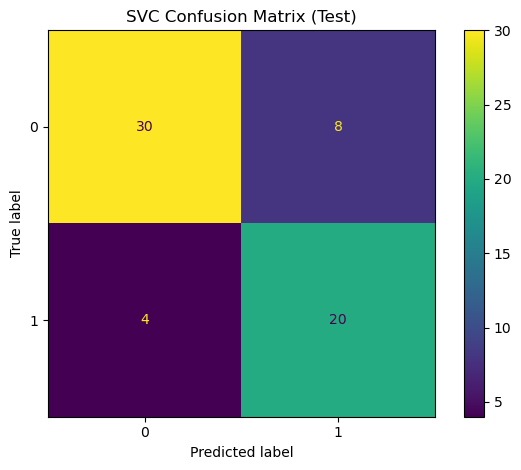

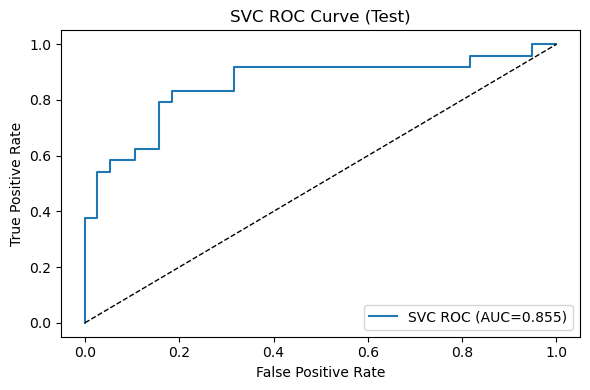

Best params: {'svc__C': 5, 'svc__kernel': 'linear'}
Best CV score: 0.5970899276162435


In [100]:
res = train_svc_regime_classifier(df, target_col="regime", tune=True, scoring="f1")
print("Best params:", res["best_params"])
print("Best CV score:", res["best_cv_score"])


### Stacking Model (no func version)

In [101]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

In [102]:
# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, ConfusionMatrixDisplay)

# 1) Data (binary target 'regime'), ordered by time
# df = stage01_component02_data.sort_index()
X = df.drop(columns=['regime'])
y = df['regime'].astype(int)

# (You said you'll handle shift(1) yourself — nothing here.)

# # 2) Basic NA handling
# X = X.ffill().bfill()
# mask = ~X.isna().any(axis=1)
# X, y = X.loc[mask], y.loc[mask]

# 3) Chronological split (last 20% as test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4) Base learners (with reasonable defaults)
rf  = RandomForestClassifier(n_estimators=600, class_weight='balanced',
                             random_state=42, n_jobs=-1)
svc = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,
          class_weight='balanced', random_state=42)
gnb = GaussianNB(var_smoothing=1e-9)

# 5) Stacking meta-learner (multinomial LR if multiclass; here binary)
meta = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')

# 6) Full pipeline: impute -> scale -> stacking
stack = StackingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('gnb', gnb)],
    final_estimator=meta,
    stack_method='predict_proba',     # use base learners' probabilities as meta features
    passthrough=False,                # set True if you also want raw X appended to meta features
    cv=TimeSeriesSplit(n_splits=5)    # out-of-fold preds for meta-learner (time-series safe)
)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('stack', stack)
])

# 7) Hyperparameter grid (you can widen later)
#    NOTE: parameter names are prefixed with 'stack__' and then the estimator name.
param_grid = {
    # RF knobs
    'stack__rf__n_estimators': [300, 600],
    'stack__rf__max_depth'   : [None, 8, 16],
    'stack__rf__min_samples_leaf': [1, 2, 5],

    # SVC (kernel trick + soft margin)
    'stack__svc__kernel': ['linear', 'rbf'],
    'stack__svc__C'     : [0.5, 1, 5, 10],        # soft-margin penalty
    'stack__svc__gamma' : ['scale', 'auto'],      # only used for rbf

    # GNB
    'stack__gnb__var_smoothing': [1e-9, 1e-8, 1e-7],

    # Meta logistic
    'stack__final_estimator__C': [0.1, 1, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)

gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1',      # or 'roc_auc'
    n_jobs=-1,
    refit=True,
    verbose=0
)

# 8) Fit on train
gcv.fit(X_train, y_train)
best_model = gcv.best_estimator_
print("Best params:", gcv.best_params_)
print("Best CV score:", gcv.best_score_)

# 9) Evaluate on test
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=3))

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title("Stacked RF+SVC+GNB → Meta-Logit (Test)")
plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Stacking ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Stacking, Test)')
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# 10) (Optional) Inspect base learners' out-of-fold/meta features on train
stack_fitted = best_model.named_steps['stack']
# After fitting, each base estimator is in stack_fitted.estimators_
# You can also get test-set base probabilities:
base_test_probs = np.column_stack([
    est.predict_proba(best_model.named_steps['scaler'].transform(
        best_model.named_steps['imputer'].transform(X_test)))[:, 1]
    for est in stack_fitted.estimators_
])
base_test_probs_df = pd.DataFrame(base_test_probs, columns=['rf_p1','svc_p1','gnb_p1'], index=X_test.index)
base_test_probs_df.head()


ValueError: 
All the 17280 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17280 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/ensemble/_stacking.py", line 706, in fit
    return super().fit(X, y_encoded, **fit_params)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/ensemble/_stacking.py", line 253, in fit
    predictions = Parallel(n_jobs=self.n_jobs)(
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 82, in __call__
    return super().__call__(iterable_with_config_and_warning_filters)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/joblib/parallel.py", line 1986, in __call__
    return output if self.return_generator else list(output)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/joblib/parallel.py", line 1914, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 147, in __call__
    return self.function(*args, **kwargs)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "/opt/miniconda3/envs/fre6123/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 1212, in cross_val_predict
    raise ValueError("cross_val_predict only works for partitions")
ValueError: cross_val_predict only works for partitions


### Stacking Model (encapsulate func versoin)